In [1]:
import os
import csv
import glob
import math
import cv2
import numpy as np
from time import time
import mediapipe as mp
import matplotlib.pyplot as plt
import pandas as pd
from collections import Counter
from mpl_toolkits.mplot3d import Axes3D
import json

In [2]:
# Initializing mediapipe pose class.
mp_pose = mp.solutions.pose

# Setting up the Pose function.
pose = mp_pose.Pose(static_image_mode=True, min_detection_confidence=0.3, model_complexity=2)

# Initializing mediapipe drawing class, useful for annotation.
mp_drawing = mp.solutions.drawing_utils 

I0000 00:00:1705436617.455757 3592672 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1705436617.489589 3592807 gl_context.cc:344] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 530.30.02), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2


In [3]:
# Data path
media_path = '/home/duong/git/Biomechanics/dataset/patient_2_bouding_box'
# print(os.listdir(media_path))

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


In [4]:
def detectPose(image, pose, bounding_box_file, display=True):
    image = cv2.resize(image, (640, 480))
    # Create a copy of the input image.
    output_image = image.copy()
    
    # Convert the image from BGR into RGB format.
    imageRGB = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Perform the Pose Detection.
    results = pose.process(imageRGB)
    
    # Retrieve the height and width of the input image.
    height, width, _ = image.shape
    
    # Load bounding box information from JSON file.
    with open(bounding_box_file, 'r') as file:
        bounding_boxes_data = json.load(file)
    
    # Get bounding box coordinates.
    bounding_box = bounding_boxes_data["bounding_boxes"][0]
    x_min, y_min, x_max, y_max = bounding_box["x_min"], bounding_box["y_min"], bounding_box["x_max"], bounding_box["y_max"]

    # Initialize a list to store the detected landmarks.
    landmarks = []
    
    # Check if any landmarks are detected.
    if results.pose_landmarks:
    
        # Draw Pose landmarks on the output image.
        mp_drawing.draw_landmarks(image=output_image, landmark_list=results.pose_landmarks,
                                  connections=mp_pose.POSE_CONNECTIONS)
        # Lấy tọa độ chân và lông mày
        cx1, cy1 = 0, 0
        cx2, cy2 = 0, 0
        
        for id, lm in enumerate(results.pose_landmarks.landmark):
            lst = []
            n = 0
            lst[n] = lst.append([id, lm.x, lm.y])
            n+1
            h, w, c = image.shape
            # Lấy tọa độ chân
            if id == 32 or id == 31:
                cx1, cy1 = int(lm.x * w), int(lm.y * h)
            # Lấy tọa độ lông mày
            if id == 6:
                cx2, cy2 = int(lm.x * w), int(lm.y * h)
                cy2 = cy2 + 20

        # Tính chiều cao thật từ lông mày đến chân
        real_height = ((cx2 - cx1) ** 2 + (cy2 - cy1) ** 2) ** 0.5

        # Tính tỉ lệ khoảng cách theo chiều cao thật
        scale_factor = real_height / (y_max - y_min)
        # Tính chiều cao người
        person_height = scale_factor * 17  # 17cm là chiều dài của vật đối tượng

        # In ra chiều cao người
        cv2.putText(output_image, f"Height: {person_height:.2f} cm", (10, 30),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)
              
        # Iterate over the detected landmarks.
        for landmark in results.pose_landmarks.landmark:
            
            # Append the landmark into the list.
            landmarks.append((int(landmark.x * width), int(landmark.y * height), (landmark.z * width)))
    
    # Check if the original input image and the resultant image are specified to be displayed.
    if display:
    
        # Display the original input image and the resultant image.
        plt.figure(figsize=[22,22])
        plt.subplot(121);plt.imshow(image[:,:,::-1]);plt.title("Original Image");plt.axis('off');
        plt.subplot(122);plt.imshow(output_image[:,:,::-1]);plt.title("Output Image");plt.axis('off');
           
    # Otherwise
    else:
        
        # Return the output image and the found landmarks.
        return output_image, landmarks

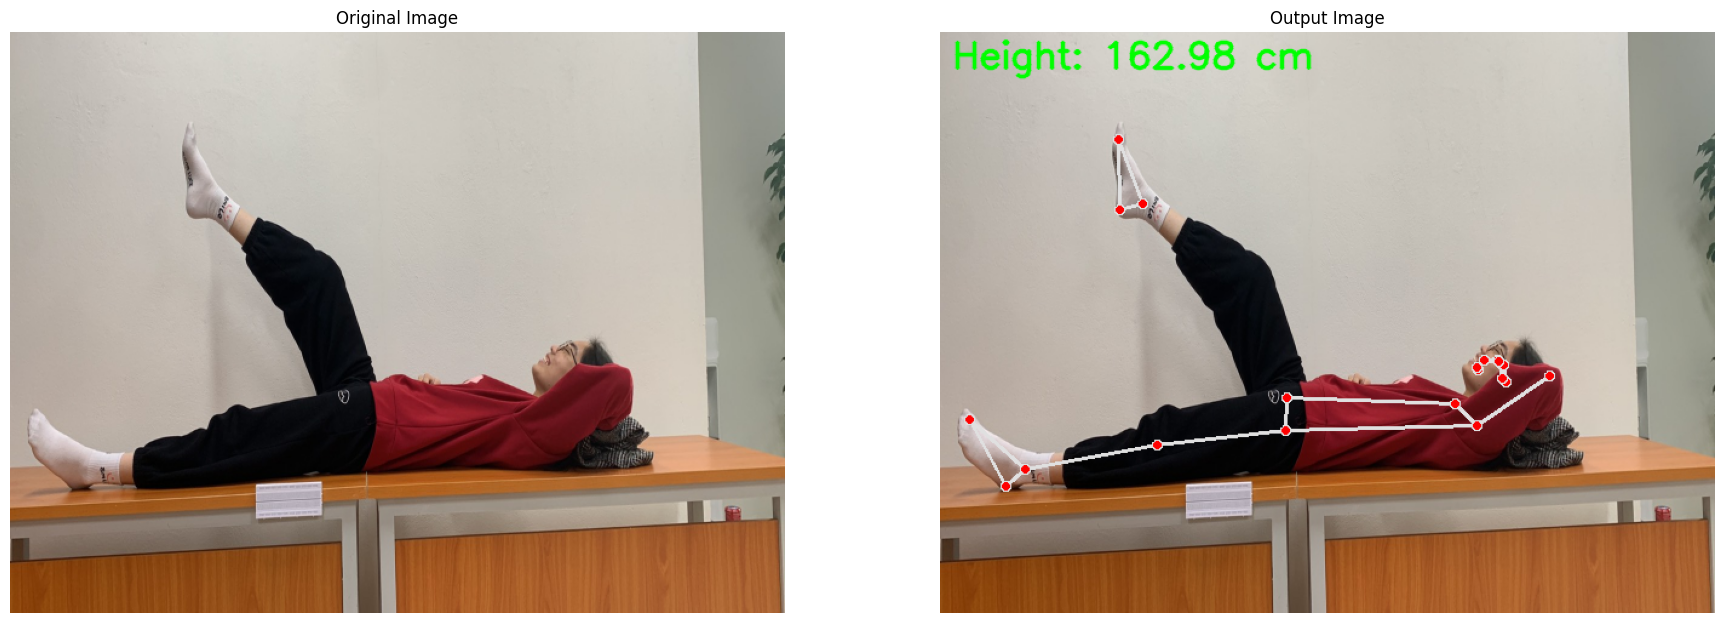

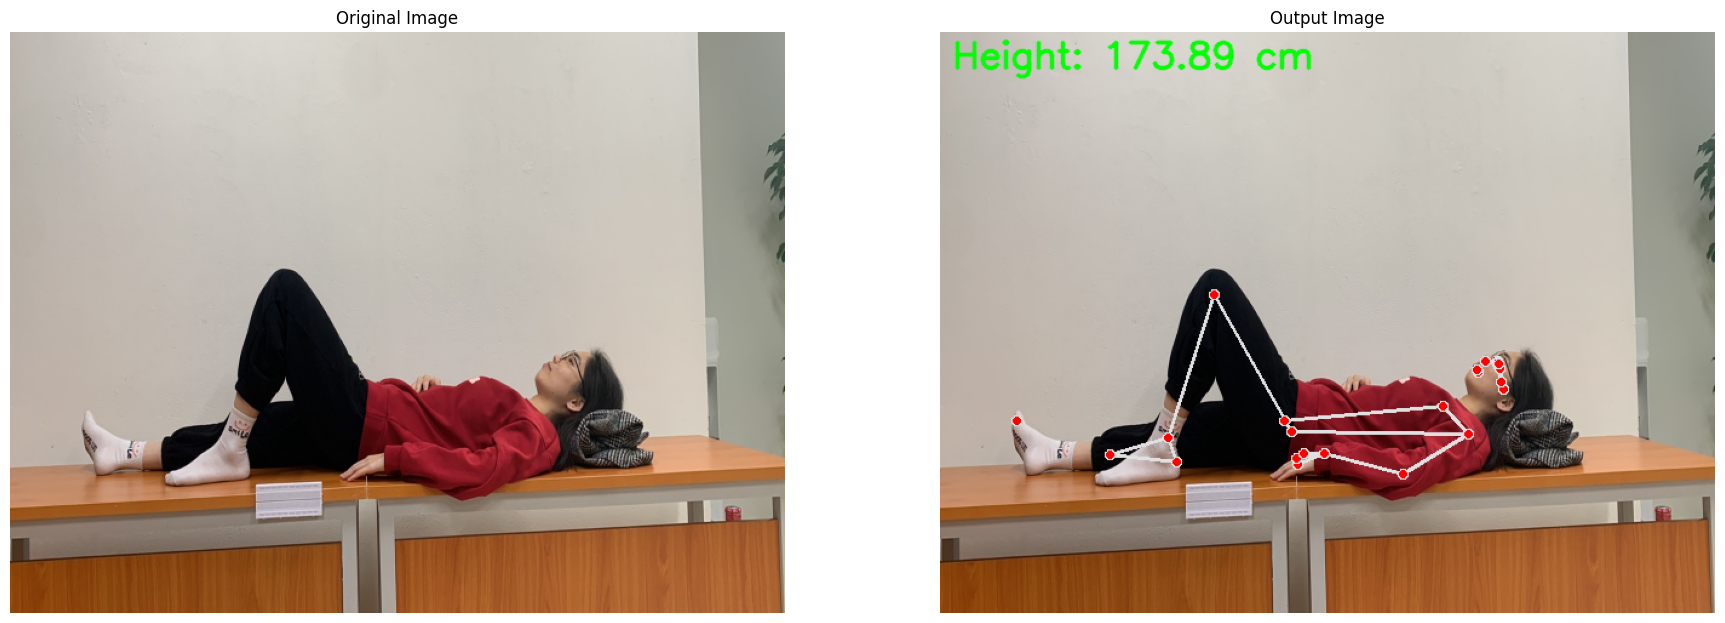

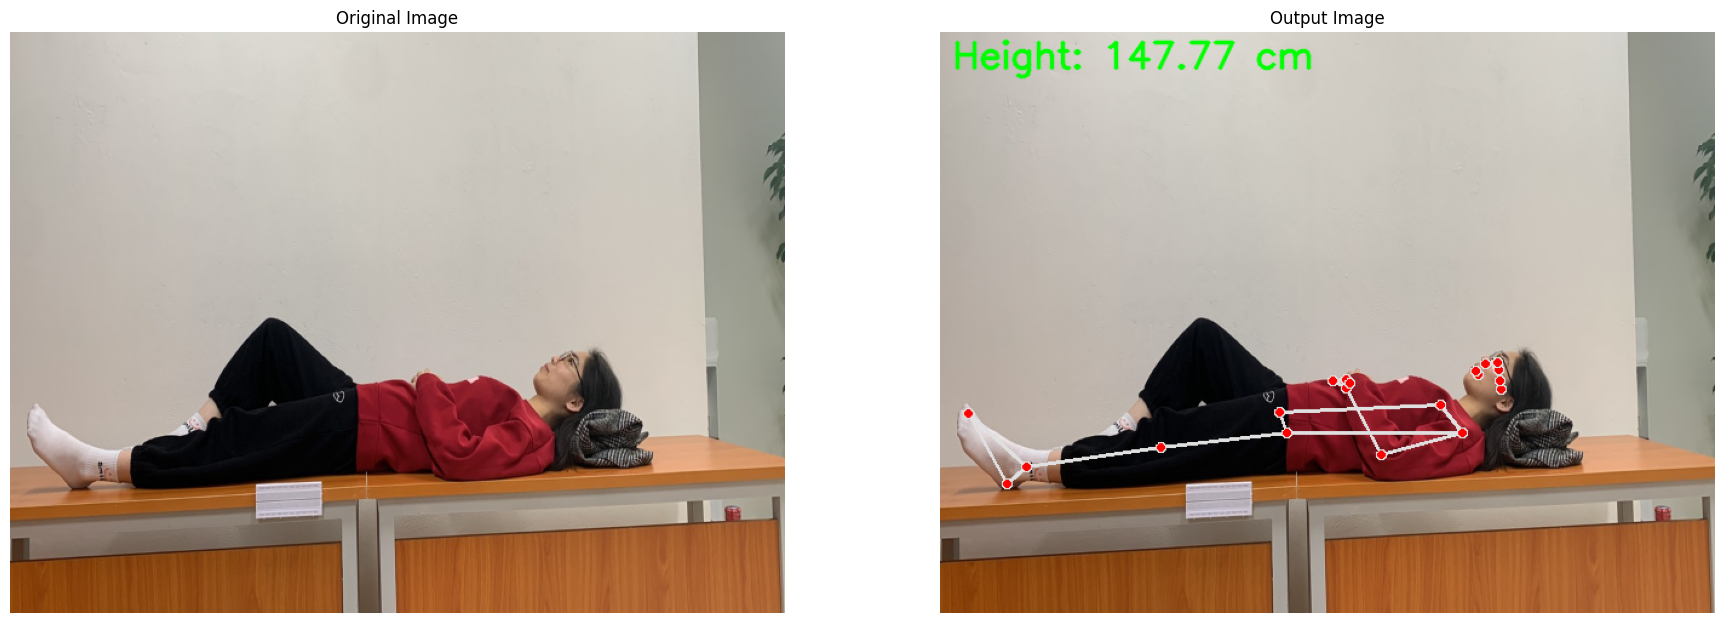

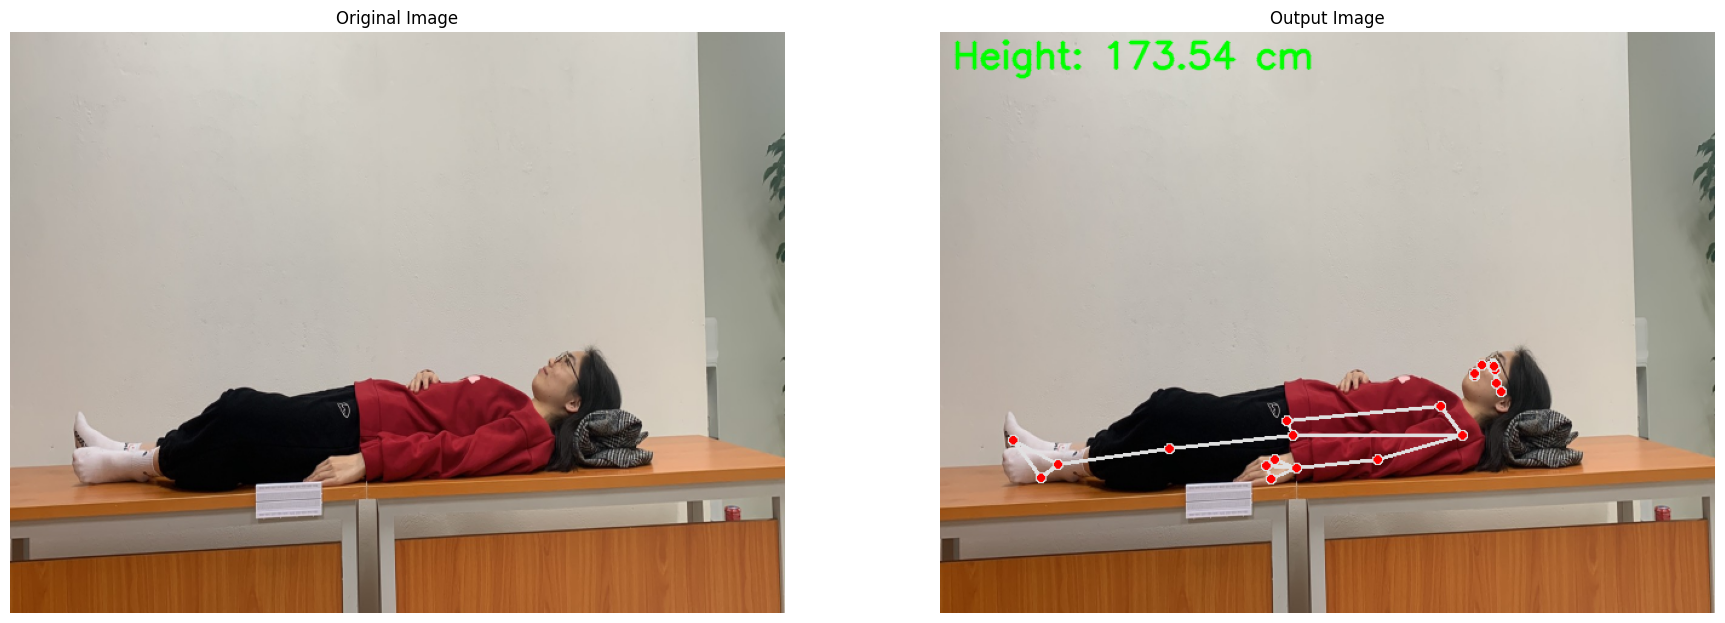

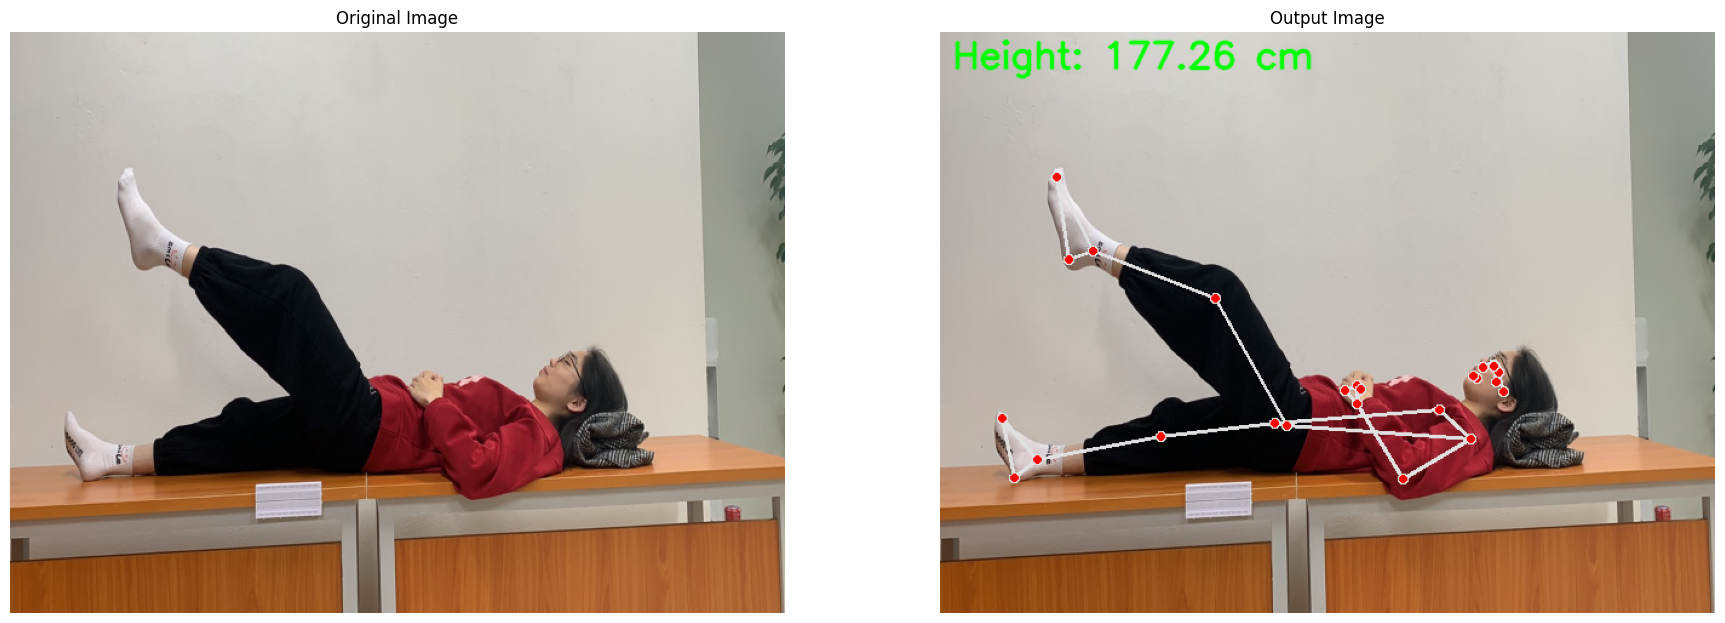

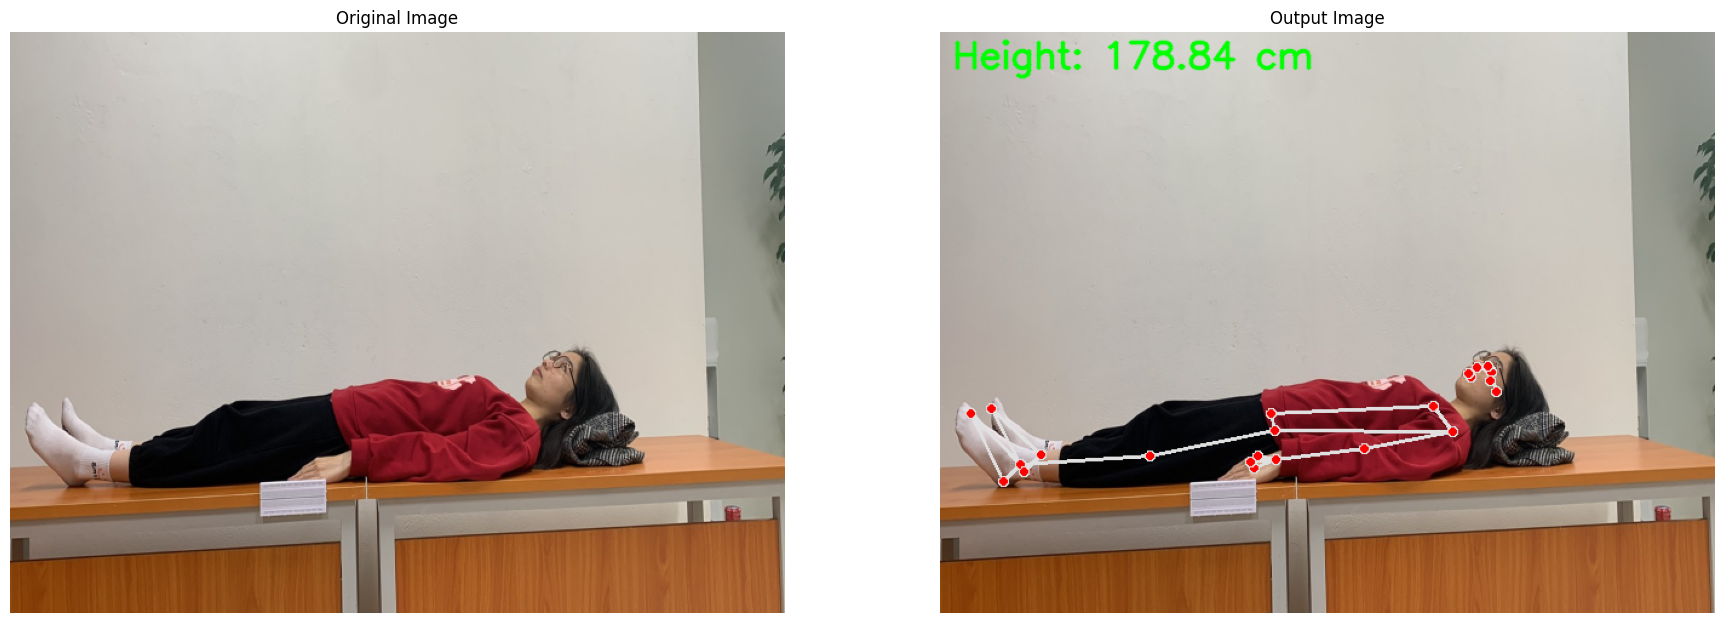

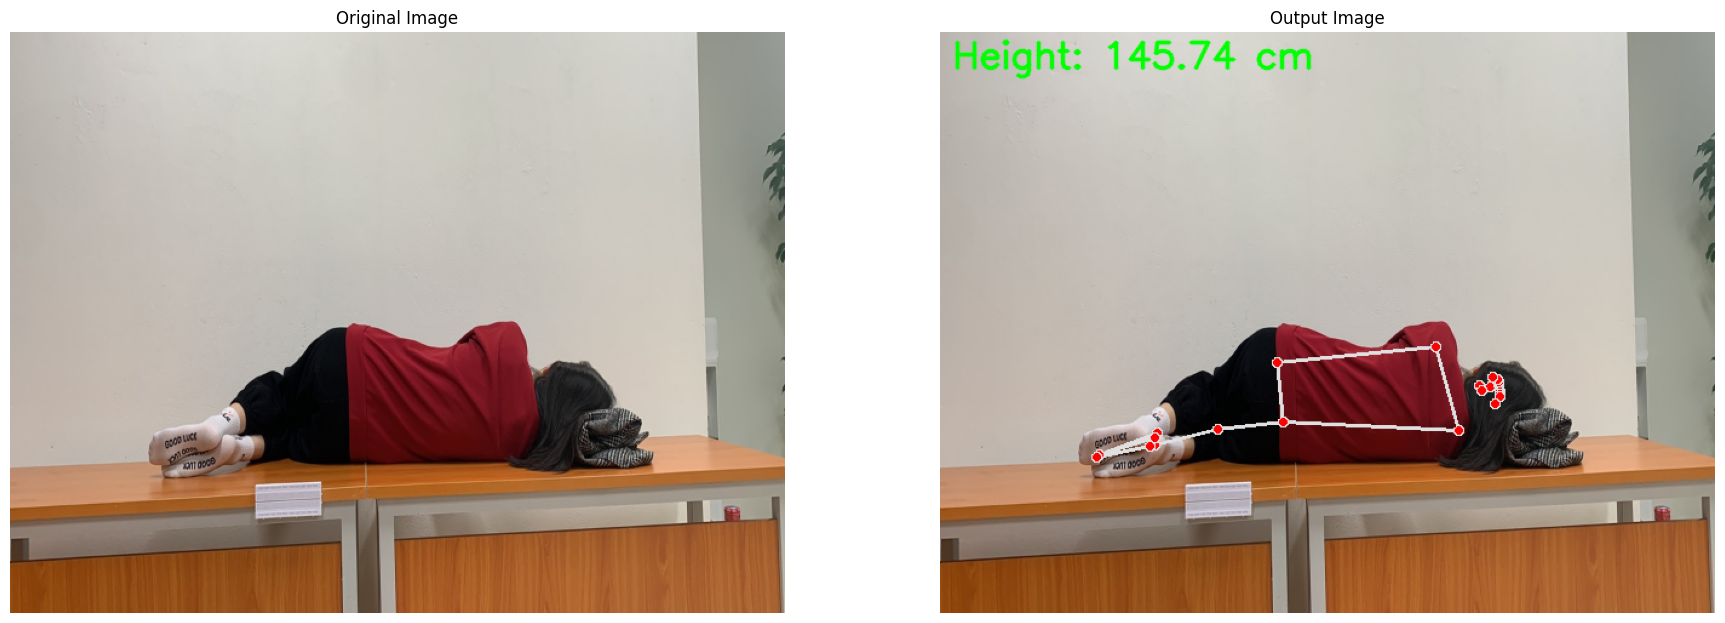

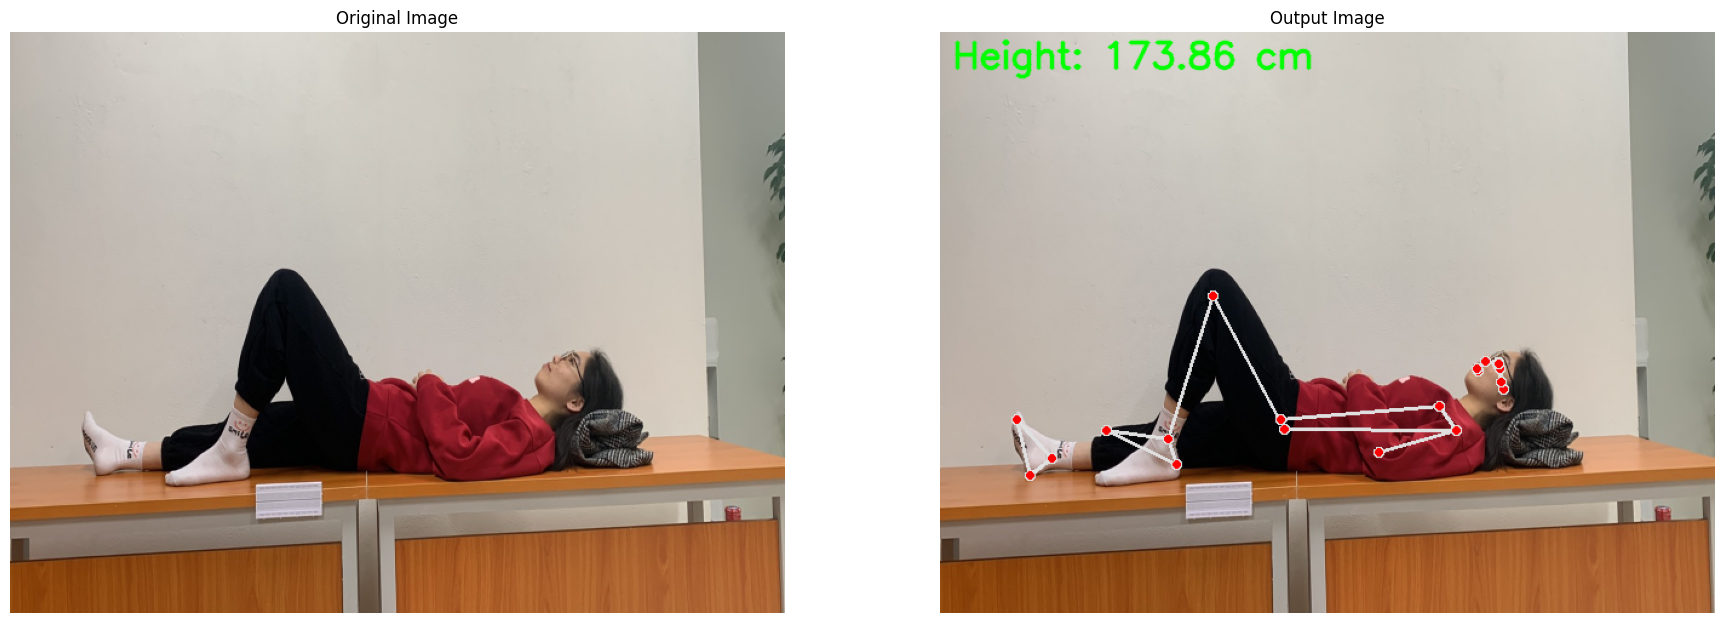

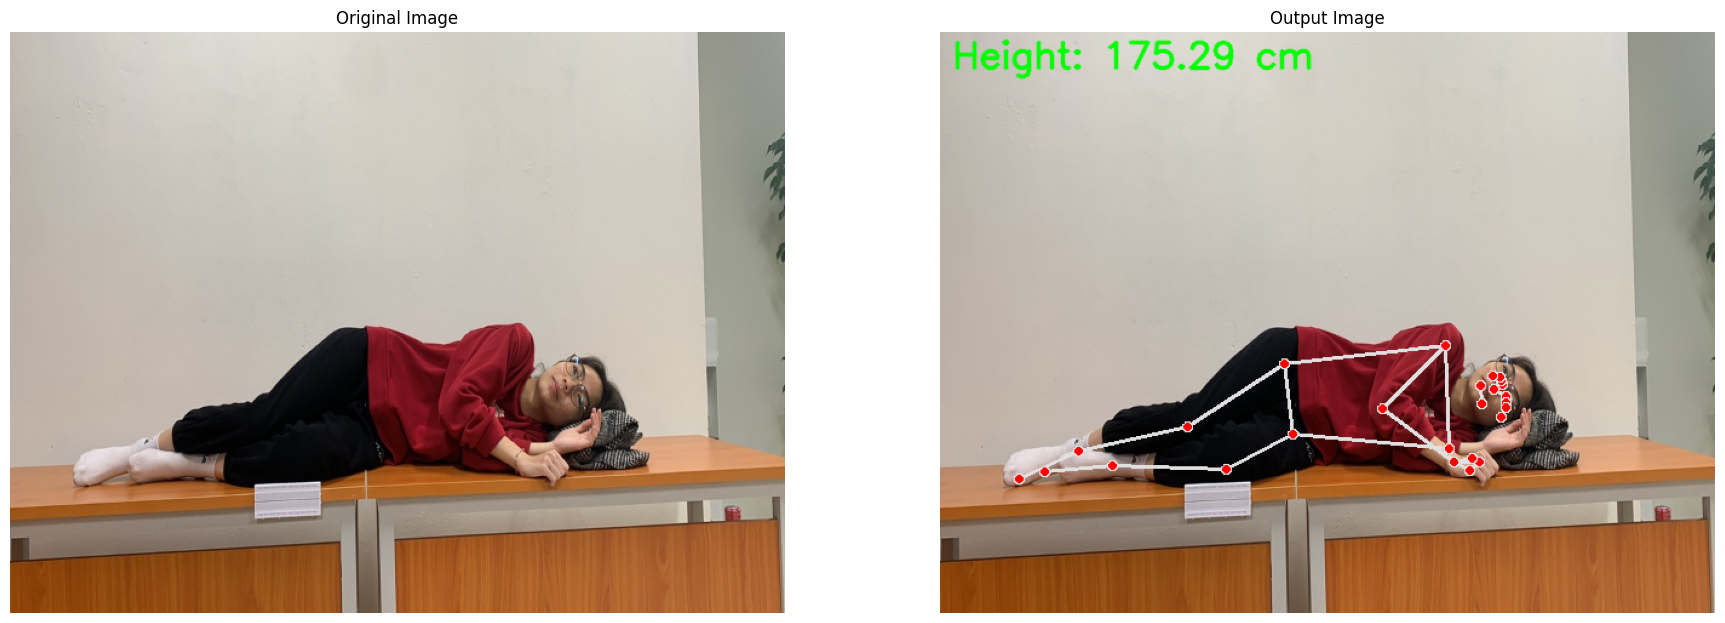

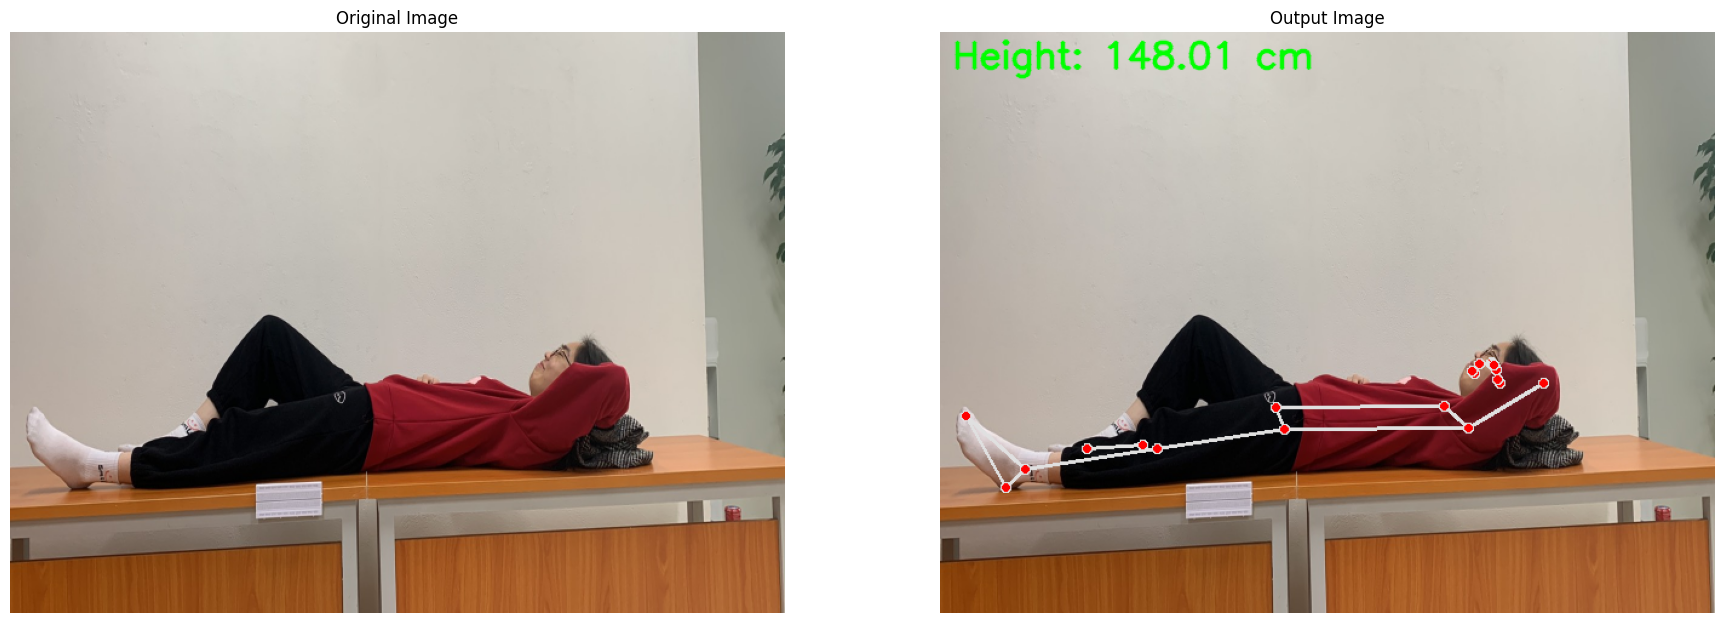

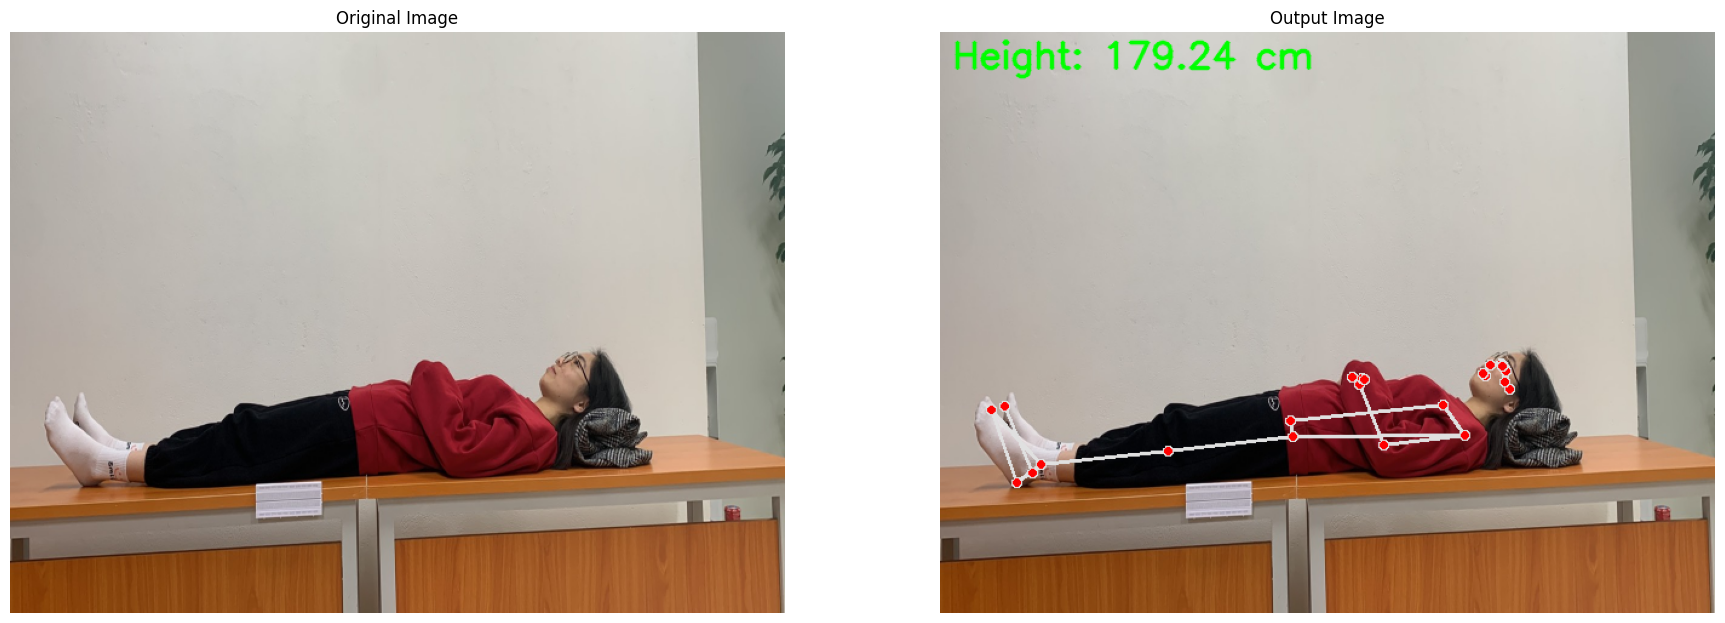

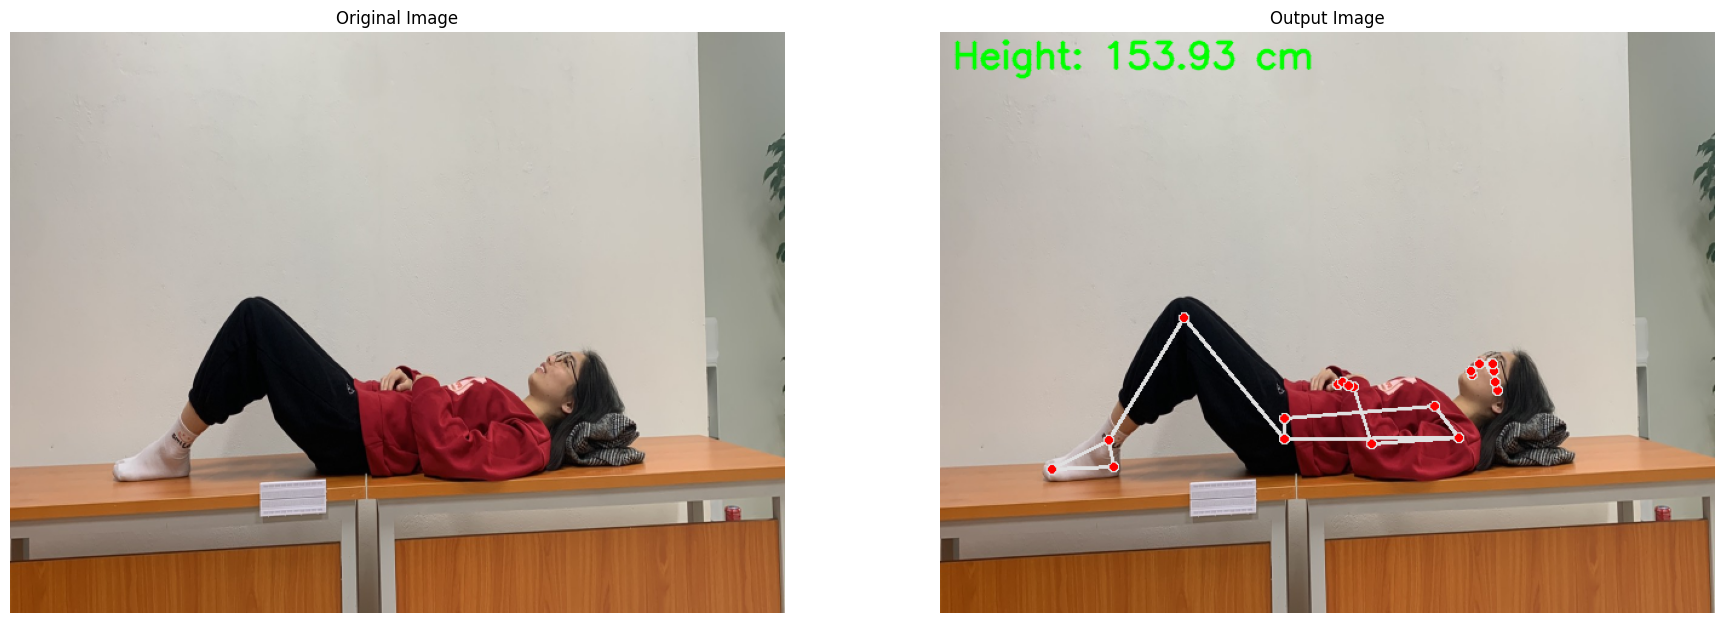

In [5]:
# Lấy danh sách đường dẫn đầy đủ đến các tệp hình ảnh trong thư mục media
image_paths = [os.path.join(media_path, file) for file in os.listdir(media_path)
               if os.path.isfile(os.path.join(media_path, file))
               and file.lower().endswith(('.jpg', '.jpeg', '.png'))]

# Loop qua từng đường dẫn ảnh và áp dụng detectPose() lên mỗi ảnh
for img_path in image_paths:
    # Đọc ảnh từ đường dẫn
    image = cv2.imread(img_path)
    
    # Thực hiện pose detection trên ảnh
    detectPose(image, pose, bounding_box_file="/home/duong/git/Biomechanics/2D/object_bounding_boxes.json", display=True)  # Set display to True để hiển thị ảnh và landmarks